In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from scipy.stats import norm

from qiskit import QuantumRegister, QuantumCircuit
from qiskit.circuit.library import IntegerComparator,WeightedAdder, LinearAmplitudeFunction

from qiskit_algorithms import IterativeAmplitudeEstimation, EstimationProblem

from qiskit_aer.primitives import Sampler

from qiskit_finance.circuit.library import GaussianConditionalIndependenceModel as GCI

In [2]:
data = {}

In [3]:
K = 5
n_z = K
z_max = 2
z_values = np.linspace(-z_max, z_max, 2**K)
p_zeros = [0.15, 0.25, 0.5, 0.11, 0.32]
rhos = [0.1, 0.05, 0.08, 0.23, 0.08]
lgd = [1, 2, 3, 4, 2]
alpha = 0.05

In [4]:
u = GCI(n_z, z_max, p_zeros, rhos)

In [5]:
u_measure = u.measure_all(inplace=False)
sampler = Sampler()
job = sampler.run(u_measure)
binary_probabilities = job.result().quasi_dists[0].binary_probabilities()

In [6]:
p_z = np.zeros(2**n_z)
p_default = np.zeros(K)
values = []
probabilities = []
num_qubits = u.num_qubits

for i, prob in binary_probabilities.items():
    # extract value of Z and corresponding probability
    i_normal = int(i[-n_z:], 2)
    p_z[i_normal] += prob
    
    # determine overall default probability for k
    loss = 0
    for k in range(K):
        if i[K - k - 1] == "1":
            p_default[k] += prob
            loss += lgd[k]

    values += [loss]
    probabilities += [prob]

    
values = np.array(values)
probabilities = np.array(probabilities)



exact_expected_loss = np.dot(values, probabilities)
losses = np.sort(np.unique(values))
pdf = np.zeros(len(losses))
for i, v in enumerate(losses):
    pdf[i] += sum(probabilities[values == v])
cdf = np.cumsum(pdf)

i_var = np.argmax(cdf >= 1 - alpha)
exact_var = losses[i_var]
exact_cvar = np.dot(pdf[(i_var + 1) :], losses[(i_var + 1) :]) / sum(pdf[(i_var + 1) :])

In [7]:
print("Expected Loss E[L]:                %.4f" % exact_expected_loss)
print("Value at Risk VaR[L]:              %.4f" % exact_var)
print("P[L <= VaR[L]]:                    %.4f" % cdf[exact_var])
print("Conditional Value at Risk CVaR[L]: %.4f" % exact_cvar)

Expected Loss E[L]:                3.2490
Value at Risk VaR[L]:              8.0000
P[L <= VaR[L]]:                    0.9629
Conditional Value at Risk CVaR[L]: 9.9211


In [8]:
data["Emperical Calculation"] = (exact_expected_loss,exact_var,exact_cvar)

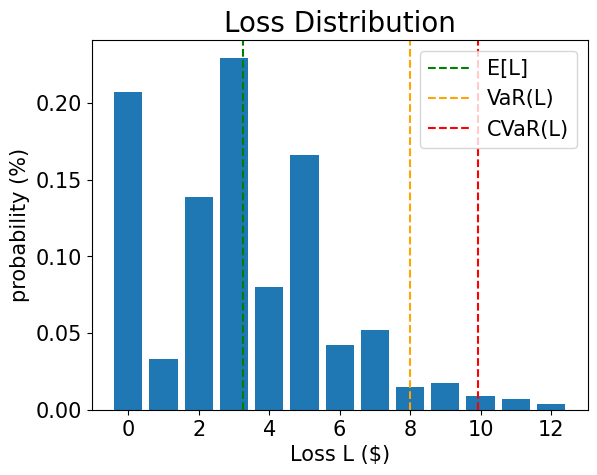

In [9]:
plt.bar(losses, pdf)
plt.axvline(exact_expected_loss, color="green", linestyle="--", label="E[L]")
plt.axvline(exact_var, color="orange", linestyle="--", label="VaR(L)")
plt.axvline(exact_cvar, color="red", linestyle="--", label="CVaR(L)")
plt.legend(fontsize=15)
plt.xlabel("Loss L ($)", size=15)
plt.ylabel("probability (%)", size=15)
plt.title("Loss Distribution", size=20)
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

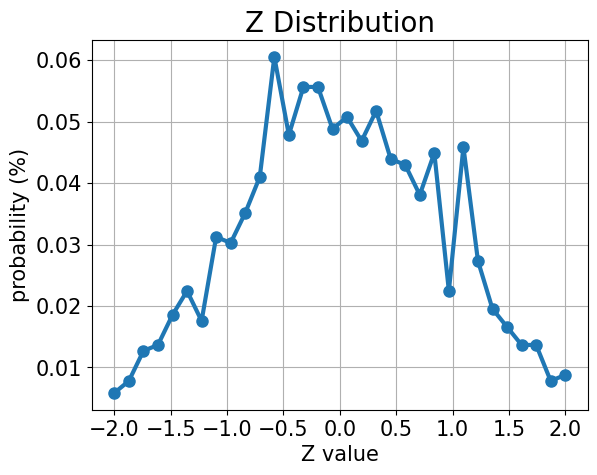

In [10]:
plt.plot(z_values, p_z, "o-", linewidth=3, markersize=8)
plt.grid()
plt.xlabel("Z value", size=15)
plt.ylabel("probability (%)", size=15)
plt.title("Z Distribution", size=20)
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

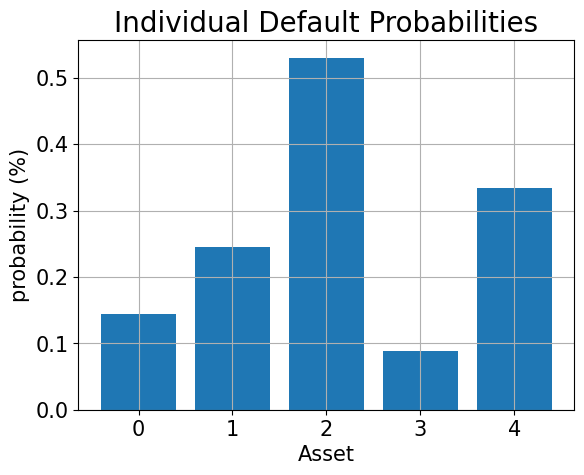

In [11]:
plt.bar(range(K), p_default)
plt.xlabel("Asset", size=15)
plt.ylabel("probability (%)", size=15)
plt.title("Individual Default Probabilities", size=20)
plt.xticks(range(K), size=15)
plt.yticks(size=15)
plt.grid()
plt.show()

# Classical Simulation

In [12]:
rhos_np = np.array(rhos)
lgd_np = np.array(lgd)
probit_thresholds = norm.ppf(p_zeros)
number_simulations = 10000

In [13]:
def simulate_potfolio_losses_classsic():
    losses = np.zeros(number_simulations)
    
    for i in range(number_simulations):
        F = np.random.normal(0, 1, K)
        z = np.random.choice(z_values, p=p_z)
        credit_events = (
            np.sqrt(rhos_np ) * z + 
            np.sqrt(1 - rhos_np) * F
        )
        defaults = credit_events < probit_thresholds
        losses[i] = np.sum(defaults * lgd_np)
    
    return losses

def calculate_var_cvar(losses, alpha=0.05):
    e_loss = np.mean(losses)
    var = np.percentile(losses, (1-alpha) * 100)
    cvar = np.mean(losses[losses >= var])
    return e_loss, var, cvar

In [14]:
classical_losses = simulate_potfolio_losses_classsic()
classical_expected_losses, classical_var, classical_cvar = calculate_var_cvar(losses=classical_losses)
data["Classical Monte Carlo"] = (classical_expected_losses, classical_var, classical_cvar)

In [15]:
print("Expected Loss E[L]:       %.4f" % exact_expected_loss)
print("Estimated Expected Losses:%.4f" % classical_expected_losses)
print("#" * 25)

print("Exact Value at Risk:     %2d" % exact_var)
print("Estimated Value at Risk: %2d" % classical_var)

print("#" * 25)

print("Exact CVaR:    \t%.4f" % exact_cvar)
print("Estimated CVaR:\t%.4f" % classical_cvar)

Expected Loss E[L]:       3.2490
Estimated Expected Losses:3.2114
#########################
Exact Value at Risk:      8
Estimated Value at Risk:  8
#########################
Exact CVaR:    	9.9211
Estimated CVaR:	9.1308


# Quantum Simulation

## Expected Loss

In [16]:
agg = WeightedAdder(n_z + K, [0] * n_z + lgd)

In [17]:
breakpoints = [0]
slopes = [1]
offsets = [0]
f_min = 0
f_max = sum(lgd)
c_approx = 0.25

objective = LinearAmplitudeFunction(
    agg.num_sum_qubits,
    slope=slopes,
    offset=offsets,
    # max value that can be reached by the qubit register (will not always be reached)
    domain=(0, 2**agg.num_sum_qubits - 1),
    image=(f_min, f_max),
    rescaling_factor=c_approx,
    breakpoints=breakpoints,
)

In [18]:
# define the registers for convenience and readability
qr_state = QuantumRegister(u.num_qubits, "state")
qr_sum = QuantumRegister(agg.num_sum_qubits, "sum")
qr_carry = QuantumRegister(agg.num_carry_qubits, "carry")
qr_obj = QuantumRegister(1, "objective")
qr_control = QuantumRegister(1, "control")

# define the circuit
state_preparation = QuantumCircuit(qr_state, qr_obj, qr_sum, qr_carry, qr_control ,name="A")

state_preparation.draw()

# load the random variable
state_preparation.append(u.to_gate(), qr_state)

# aggregate
state_preparation.append(agg.to_gate(), qr_state[:] + qr_sum[:] + qr_carry[:] + qr_control[:])

# # linear objective function
state_preparation.append(objective.to_gate(), qr_sum[:] + qr_obj[:])

# # uncompute aggregation
state_preparation.append(agg.to_gate().inverse(), qr_state[:] + qr_sum[:] + qr_carry[:] + qr_control[:])

In [19]:
state_preparation.draw()

┌───────┐┌─────────┐      ┌────────────┐
  state_0: ┤0      ├┤0        ├──────┤0           ├
           │       ││         │      │            │
  state_1: ┤1      ├┤1        ├──────┤1           ├
           │       ││         │      │            │
  state_2: ┤2      ├┤2        ├──────┤2           ├
           │       ││         │      │            │
  state_3: ┤3      ├┤3        ├──────┤3           ├
           │       ││         │      │            │
  state_4: ┤4      ├┤4        ├──────┤4           ├
           │  P(X) ││         │      │            │
  state_5: ┤5      ├┤5        ├──────┤5           ├
           │       ││         │      │            │
  state_6: ┤6      ├┤6        ├──────┤6           ├
           │       ││         │      │            │
  state_7: ┤7      ├┤7        ├──────┤7           ├
           │       ││         │      │            │
  state_8: ┤8      ├┤8        ├──────┤8           ├
           │       ││         │      │            │
  state_9: ┤9      ├┤9  adder ├──────┤9  adder_dg ├
           └───────┘│         │┌────┐│            │
objective: ─────────┤         ├┤4   ├┤            ├
                    │         ││    ││            │
    sum_0: ─────────┤10       ├┤0   ├┤10          ├
                    │         ││    ││            │
    sum_1: ─────────┤11       ├┤1 F ├┤11          ├
                    │         ││    ││            │
    sum_2: ─────────┤12       ├┤2   ├┤12          ├
                    │         ││    ││            │
    sum_3: ─────────┤13       ├┤3   ├┤13          ├
                    │         │└────┘│            │
  carry_0: ─────────┤14       ├──────┤14          ├
                    │         │      │            │
  carry_1: ─────────┤15       ├──────┤15          ├
                    │         │      │            │
  carry_2: ─────────┤16       ├──────┤16          ├
                    │         │      │            │
  control: ─────────┤17       ├──────┤17          ├
                    └─────────┘      └────────────┘

In [20]:
state_preparation_measure = state_preparation.measure_all(inplace=False)
sampler = Sampler()
job = sampler.run(state_preparation_measure)
binary_probabilities = job.result().quasi_dists[0].binary_probabilities()

### Validation Run - Direct Simulation

In [21]:
value = 0
for i, prob in binary_probabilities.items():
    if prob > 1e-6 and i[-(len(qr_state) + 1) :][0] == "1":
        value += prob

print("Exact Expected Loss:   %.4f" % exact_expected_loss)
print("Exact Operator Value:  %.4f" % value)
print("Mapped Operator value: %.4f" % objective.post_processing(value))

Exact Expected Loss:   3.2490
Exact Operator Value:  0.3652
Mapped Operator value: 1.8819


### Quantum Amplitude Estimation

In [22]:
epsilon = 0.01
alpha = 0.05

problem = EstimationProblem(
    state_preparation=state_preparation,
    objective_qubits=[len(qr_state)],
    post_processing=objective.post_processing,
)
# construct amplitude estimation
ae = IterativeAmplitudeEstimation(
    epsilon_target=epsilon, alpha=alpha, sampler=Sampler(run_options={"shots": 100, "seed": 75})
)
result = ae.estimate(problem)

# print results
conf_int = np.array(result.confidence_interval_processed)
qc_expected_loss = result.estimation_processed

print("Exact Expected Loss value:    \t%.4f" % exact_expected_loss)
print("Estimated Expected Loss value:\t%.4f" % qc_expected_loss)
print("Confidence interval: \t[%.4f, %.4f]" % tuple(conf_int))

Exact Expected Loss value:    	3.2490
Estimated Expected Loss value:	3.2316
Confidence interval: 	[3.0126, 3.4506]


### Cumulative Distribution Function

In [23]:
x_eval = 3

comparator = IntegerComparator(agg.num_sum_qubits, x_eval + 1, geq=False)


In [24]:
comparator.draw()

┌──────┐
state_0: ┤0     ├
         │      │
state_1: ┤1     ├
         │      │
state_2: ┤2     ├
         │      │
state_3: ┤3     ├
         │  cmp │
compare: ┤4     ├
         │      │
  a15_0: ┤5     ├
         │      │
  a15_1: ┤6     ├
         │      │
  a15_2: ┤7     ├
         └──────┘

In [25]:
def get_cdf_circuit(x_eval):
    # define the registers for convenience and readability
    qr_state = QuantumRegister(u.num_qubits, "state")
    qr_sum = QuantumRegister(agg.num_sum_qubits, "sum")
    qr_carry = QuantumRegister(agg.num_carry_qubits, "carry")
    qr_obj = QuantumRegister(1, "objective")
    qr_compare = QuantumRegister(1, "compare")
    qr_control = QuantumRegister(1, "control")

    # define the circuit
    state_preparation = QuantumCircuit(qr_state, qr_obj, qr_sum, qr_carry,qr_control, name="A")

    # load the random variable
    state_preparation.append(u, qr_state)

    # aggregate
    state_preparation.append(agg, qr_state[:] + qr_sum[:] + qr_carry[:] + qr_control[:])

    # comparator objective function
    comparator = IntegerComparator(agg.num_sum_qubits, x_eval + 1, geq=False)
    state_preparation.append(comparator, qr_sum[:] + qr_obj[:] + qr_carry[:])

    # uncompute aggregation
    state_preparation.append(agg.inverse(), qr_state[:] + qr_sum[:] + qr_carry[:] + qr_control[:])

    return state_preparation

In [26]:
state_preparation = get_cdf_circuit(x_eval)


In [27]:
state_preparation.draw()

┌───────┐┌─────────┐        ┌────────────┐
  state_0: ┤0      ├┤0        ├────────┤0           ├
           │       ││         │        │            │
  state_1: ┤1      ├┤1        ├────────┤1           ├
           │       ││         │        │            │
  state_2: ┤2      ├┤2        ├────────┤2           ├
           │       ││         │        │            │
  state_3: ┤3      ├┤3        ├────────┤3           ├
           │       ││         │        │            │
  state_4: ┤4      ├┤4        ├────────┤4           ├
           │  P(X) ││         │        │            │
  state_5: ┤5      ├┤5        ├────────┤5           ├
           │       ││         │        │            │
  state_6: ┤6      ├┤6        ├────────┤6           ├
           │       ││         │        │            │
  state_7: ┤7      ├┤7        ├────────┤7           ├
           │       ││         │        │            │
  state_8: ┤8      ├┤8        ├────────┤8           ├
           │       ││         │        │            │
  state_9: ┤9      ├┤9  adder ├────────┤9  adder_dg ├
           └───────┘│         │┌──────┐│            │
objective: ─────────┤         ├┤4     ├┤            ├
                    │         ││      ││            │
    sum_0: ─────────┤10       ├┤0     ├┤10          ├
                    │         ││      ││            │
    sum_1: ─────────┤11       ├┤1     ├┤11          ├
                    │         ││      ││            │
    sum_2: ─────────┤12       ├┤2     ├┤12          ├
                    │         ││  cmp ││            │
    sum_3: ─────────┤13       ├┤3     ├┤13          ├
                    │         ││      ││            │
  carry_0: ─────────┤14       ├┤5     ├┤14          ├
                    │         ││      ││            │
  carry_1: ─────────┤15       ├┤6     ├┤15          ├
                    │         ││      ││            │
  carry_2: ─────────┤16       ├┤7     ├┤16          ├
                    │         │└──────┘│            │
  control: ─────────┤17       ├────────┤17          ├
                    └─────────┘        └────────────┘

In [28]:
state_preparation_measure = state_preparation.measure_all(inplace=False)
sampler = Sampler()
job = sampler.run(state_preparation_measure)
binary_probabilities = job.result().quasi_dists[0].binary_probabilities()

In [29]:
var_prob = 0
for i, prob in binary_probabilities.items():
    if prob > 1e-6 and i[-(len(qr_state) + 1) :][0] == "1":
        var_prob += prob

print("Operator CDF(%s)" % x_eval + " = %.4f" % var_prob)
print("Exact    CDF(%s)" % x_eval + " = %.4f" % cdf[x_eval])

Operator CDF(3) = 0.6465
Exact    CDF(3) = 0.6084


In [30]:
epsilon = 0.01
alpha = 0.05

problem = EstimationProblem(state_preparation=state_preparation, objective_qubits=[len(qr_state)])
# construct amplitude estimation
ae_cdf = IterativeAmplitudeEstimation(
    epsilon_target=epsilon, alpha=alpha, sampler=Sampler(run_options={"shots": 100, "seed": 75})
)
result_cdf = ae_cdf.estimate(problem)

# print results
conf_int = np.array(result_cdf.confidence_interval)
print("Exact value:    \t%.4f" % cdf[x_eval])
print("Estimated value:\t%.4f" % result_cdf.estimation)
print("Confidence interval: \t[%.4f, %.4f]" % tuple(conf_int))

Exact value:    	0.6084
Estimated value:	0.6167
Confidence interval: 	[0.6107, 0.6227]


### Value At Risk

In [31]:
def run_iae_for_cdf(x_eval, epsilon=0.01, alpha=0.05):

    # construct amplitude estimation
    state_preparation = get_cdf_circuit(x_eval)
    problem = EstimationProblem(
        state_preparation=state_preparation, objective_qubits=[len(qr_state)]
    )
    ae_var = IterativeAmplitudeEstimation(
        epsilon_target=epsilon, alpha=alpha, sampler=Sampler(run_options={"shots": 100, "seed": 75})
    )
    result_var = ae_var.estimate(problem)

    return result_var.estimation

In [32]:
def bisection_search(
    objective, target_value, low_level, high_level, low_value=None, high_value=None
):
    """
    Determines the smallest level such that the objective value is still larger than the target
    :param objective: objective function
    :param target: target value
    :param low_level: lowest level to be considered
    :param high_level: highest level to be considered
    :param low_value: value of lowest level (will be evaluated if set to None)
    :param high_value: value of highest level (will be evaluated if set to None)
    :return: dictionary with level, value, num_eval
    """

    # check whether low and high values are given and evaluated them otherwise
    print("--------------------------------------------------------------------")
    print("start bisection search for target value %.3f" % target_value)
    print("--------------------------------------------------------------------")
    num_eval = 0
    if low_value is None:
        low_value = objective(low_level)
        num_eval += 1
    if high_value is None:
        high_value = objective(high_level)
        num_eval += 1

    # check if low_value already satisfies the condition
    if low_value > target_value:
        return {
            "level": low_level,
            "value": low_value,
            "num_eval": num_eval,
            "comment": "returned low value",
        }
    elif low_value == target_value:
        return {"level": low_level, "value": low_value, "num_eval": num_eval, "comment": "success"}

    # check if high_value is above target
    if high_value < target_value:
        return {
            "level": high_level,
            "value": high_value,
            "num_eval": num_eval,
            "comment": "returned low value",
        }
    elif high_value == target_value:
        return {
            "level": high_level,
            "value": high_value,
            "num_eval": num_eval,
            "comment": "success",
        }

    # perform bisection search until
    print("low_level    low_value    level    value    high_level    high_value")
    print("--------------------------------------------------------------------")
    while high_level - low_level > 1:

        level = int(np.round((high_level + low_level) / 2.0))
        num_eval += 1
        value = objective(level)

        print(
            "%2d           %.3f        %2d       %.3f    %2d            %.3f"
            % (low_level, low_value, level, value, high_level, high_value)
        )

        if value >= target_value:
            high_level = level
            high_value = value
        else:
            low_level = level
            low_value = value

    # return high value after bisection search
    print("--------------------------------------------------------------------")
    print("finished bisection search")
    print("--------------------------------------------------------------------")
    return {"level": high_level, "value": high_value, "num_eval": num_eval, "comment": "success"}

In [33]:
objective = lambda x: run_iae_for_cdf(x)
bisection_result = bisection_search(
    objective, 1 - alpha, min(losses) - 1, max(losses), low_value=0, high_value=1
)
qc_var = bisection_result["level"]

--------------------------------------------------------------------
start bisection search for target value 0.950
--------------------------------------------------------------------
low_level    low_value    level    value    high_level    high_value
--------------------------------------------------------------------
-1           0.000         6       0.897    12            1.000
 6           0.897         9       0.988    12            1.000
 6           0.897         8       0.965     9            0.988
 6           0.897         7       0.952     8            0.965
--------------------------------------------------------------------
finished bisection search
--------------------------------------------------------------------


In [34]:
print("Exact Value at Risk:     %2d" % exact_var)
print("Estimated Value at Risk: %2d" % qc_var)
print("#" * 25)
print("Exact Probability:        %.3f" % cdf[exact_var])
print("Estimated Probability:    %.3f" % bisection_result["value"])


Exact Value at Risk:      8
Estimated Value at Risk:  7
#########################
Exact Probability:        0.963
Estimated Probability:    0.952


### Conditional Value at Risk

In [35]:
breakpoints = [0, qc_var]
slopes = [0, 1]
offsets = [0, 0]  # subtract VaR and add it later to the estimate
f_min = 0
f_max = 3 - qc_var
c_approx = 0.25

cvar_objective = LinearAmplitudeFunction(
    agg.num_sum_qubits,
    slopes,
    offsets,
    domain=(0, 2**agg.num_sum_qubits - 1),
    image=(f_min, f_max),
    rescaling_factor=c_approx,
    breakpoints=breakpoints,
)

In [36]:
cvar_objective.draw()

┌────┐
q288_0: ┤0   ├
        │    │
q288_1: ┤1   ├
        │    │
q288_2: ┤2   ├
        │    │
q288_3: ┤3   ├
        │    │
  q289: ┤4 F ├
        │    │
a133_0: ┤5   ├
        │    │
a133_1: ┤6   ├
        │    │
a133_2: ┤7   ├
        │    │
a133_3: ┤8   ├
        └────┘

In [37]:
qr_state = QuantumRegister(u.num_qubits, "state")
qr_sum = QuantumRegister(agg.num_sum_qubits, "sum")
qr_carry = QuantumRegister(agg.num_carry_qubits, "carry")
qr_obj = QuantumRegister(1, "objective")
qr_work = QuantumRegister(cvar_objective.num_ancillas - len(qr_carry), "work")
qr_control = QuantumRegister(1, "control")

# define the circuit
state_preparation = QuantumCircuit(qr_state, qr_obj, qr_sum, qr_carry, qr_work, qr_control, name="A")

# load the random variable
state_preparation.append(u, qr_state)

# aggregate
state_preparation.append(agg, qr_state[:] + qr_sum[:] + qr_carry[:] + qr_control[:])

# linear objective function
state_preparation.append(cvar_objective, qr_sum[:] + qr_obj[:] + qr_carry[:] + qr_work[:])

# uncompute aggregation
state_preparation.append(agg.inverse(), qr_state[:] + qr_sum[:] + qr_carry[:] + qr_control[:])

In [38]:
state_preparation_measure = state_preparation.measure_all(inplace=False)
sampler = Sampler()
job = sampler.run(state_preparation_measure)
binary_probabilities = job.result().quasi_dists[0].binary_probabilities()

In [39]:
value = 0
for i, prob in binary_probabilities.items():
    if prob > 1e-6 and i[-(len(qr_state) + 1)] == "1":
        value += prob

# normalize and add VaR to estimate
value = cvar_objective.post_processing(value)
d = 1.0 - bisection_result["value"]
v = value / d if d != 0 else 0
normalized_value = v + qc_var

print("Exact CVaR:     %.4f" % exact_cvar)
print("Estimated CVaR: %.4f" % normalized_value)


Exact CVaR:     9.9211
Estimated CVaR: 10.7075


In [40]:
# set target precision and confidence level
epsilon = 0.01
alpha = 0.05

problem = EstimationProblem(
    state_preparation=state_preparation,
    objective_qubits=[len(qr_state)],
    post_processing=cvar_objective.post_processing,
)
# construct amplitude estimation
ae_cvar = IterativeAmplitudeEstimation(
    epsilon_target=epsilon, alpha=alpha, sampler=Sampler(run_options={"shots": 100, "seed": 75})
)
result_cvar = ae_cvar.estimate(problem)

In [41]:
d = 1.0 - bisection_result["value"]
v = result_cvar.estimation_processed / d if d != 0 else 0
qc_cvar = v + qc_var
print("Exact CVaR:    \t%.4f" % exact_cvar)
print("Estimated CVaR:\t%.4f" % qc_cvar)

Exact CVaR:    	9.9211
Estimated CVaR:	7.6058


In [42]:
data["Qauntum Calculation"] = (qc_expected_loss, qc_var ,qc_cvar)

In [43]:
print(data)

{'Emperical Calculation': (3.2490234375, 8, 9.921052631578947), 'Classical Monte Carlo': (3.2114, 8.0, 9.13076923076923), 'Qauntum Calculation': (3.2316039625767434, 7, 7.60581650684769)}


In [44]:
# row = {"Circuit Name": name,'Absolute Error': abs_error(p, result), 'Relative Error': relative_error(p, result), 'MSE': mse(p, result)}
# data.append(row)

def abs_error(m1,m2):
    return abs(m1 - m2)

def relative_error(m1,m2):
    return abs_error(m1,m2)/abs(m1)

def mse(m1,m2):
    return (m2 - m1) ** 2

table_data =[]
table_data_el = []
table_data_var = []
table_data_cvar = []
for sim_type, sim_data in data.items():
    expected_loss, var, cvar = sim_data
    
    row = {"Simulation Type": sim_type, "Expected Loss": expected_loss, "Value at Risk": var, "Conditional Value at Risk": cvar}
    table_data.append(row)
    
    row_el = {"Simulation Type": sim_type, "Expected Loss": expected_loss, 'Absolute Error': abs_error(exact_expected_loss, expected_loss), 'Relative Error': relative_error(exact_expected_loss, expected_loss), 'MSE': mse(exact_expected_loss, expected_loss)}
    table_data_el.append(row_el)
    
    row_var = {"Simulation Type": sim_type, "Value at Risk": var, 'Absolute Error': abs_error(exact_var, var), 'Relative Error': relative_error(exact_var, var), 'MSE': mse(exact_var, var)}
    table_data_var.append(row_var)
    
    row_cvar = {"Simulation Type": sim_type, "Conditional Value at Risk": cvar, 'Absolute Error': abs_error(exact_cvar, cvar), 'Relative Error': relative_error(exact_cvar, cvar), 'MSE': mse(exact_cvar, cvar)}
    table_data_cvar.append(row_cvar)
    
df_table = pd.DataFrame(table_data)
df_table_el = pd.DataFrame(table_data_el)
df_table_var = pd.DataFrame(table_data_var)
df_table_cvar = pd.DataFrame(table_data_cvar)

In [45]:
print(df_table)

print("\n")

print(df_table_el)

print("\n")

print(df_table_var)

print("\n")

print(df_table_cvar)

print("\n")

         Simulation Type  Expected Loss  Value at Risk  \
0  Emperical Calculation       3.249023            8.0   
1  Classical Monte Carlo       3.211400            8.0   
2    Qauntum Calculation       3.231604            7.0   

   Conditional Value at Risk  
0                   9.921053  
1                   9.130769  
2                   7.605817  


         Simulation Type  Expected Loss  Absolute Error  Relative Error  \
0  Emperical Calculation       3.249023        0.000000        0.000000   
1  Classical Monte Carlo       3.211400        0.037623        0.011580   
2    Qauntum Calculation       3.231604        0.017419        0.005361   

        MSE  
0  0.000000  
1  0.001416  
2  0.000303  


         Simulation Type  Value at Risk  Absolute Error  Relative Error  MSE
0  Emperical Calculation            8.0             0.0           0.000  0.0
1  Classical Monte Carlo            8.0             0.0           0.000  0.0
2    Qauntum Calculation            7.0            

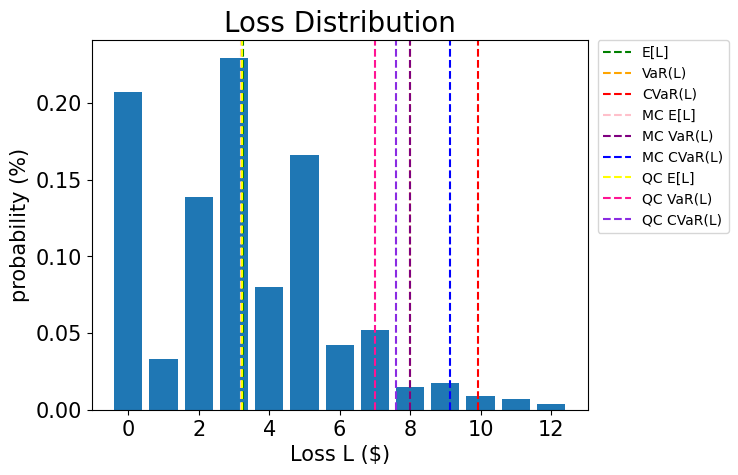

In [51]:
plt.bar(losses, pdf)

plt.axvline(exact_expected_loss, color="green", linestyle="--", label="E[L]")
plt.axvline(exact_var, color="orange", linestyle="--", label="VaR(L)")
plt.axvline(exact_cvar, color="red", linestyle="--", label="CVaR(L)")

plt.axvline(classical_expected_losses, color="pink", linestyle="--", label="MC E[L]")
plt.axvline(classical_var, color="purple", linestyle="--", label="MC VaR(L)")
plt.axvline(classical_cvar, color="blue", linestyle="--", label="MC CVaR(L)")

plt.axvline(qc_expected_loss, color="yellow", linestyle="--", label="QC E[L]")
plt.axvline(qc_var, color="deeppink", linestyle="--", label="QC VaR(L)")
plt.axvline(qc_cvar, color="blueviolet", linestyle="--", label="QC CVaR(L)")

plt.legend(fontsize=15)
plt.xlabel("Loss L ($)", size=15)
plt.ylabel("probability (%)", size=15)
plt.title("Loss Distribution", size=20)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()